# Sample input pictures, sex, and height.

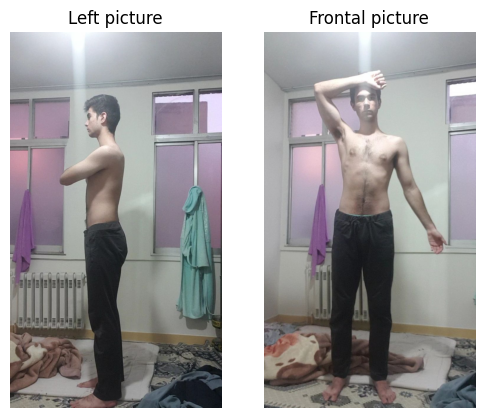

In [25]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import mediapipe as mp
import math
from Body_Part_Segmentation.human_seg.human_seg_gt import human_seg_combine_argmax
from Body_Part_Segmentation import body_parts_segmentation as BodyPartSegmentation
from Parametric_Body_Fat_Estimation.src import parametric_body_fat_estimation as ParametricBodyFatEstimation

HEIGHT = 190 # in cm
SEX = 'male' # male or female

img1 = mpimg.imread('input/Left.jpg')
img2 = mpimg.imread('input/Front.jpg')

fig, axes = plt.subplots(1, 2, figsize=(6, 5))
axes[0].set_title('Left picture')
axes[1].set_title('Frontal picture')

axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

# Estimate image depth with Depth Anything v1 large model
### (Depth_Estimation/run.py)

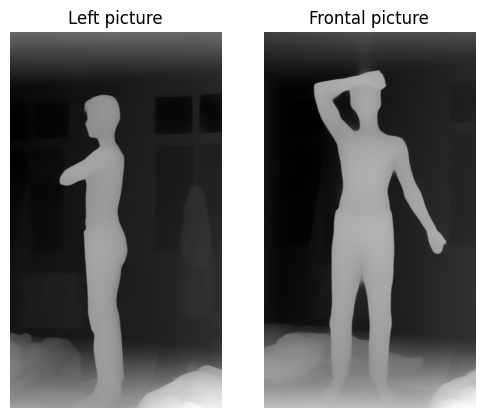

In [24]:
img1 = mpimg.imread('Depth_Estimation/output/Left_depth.png')
img2 = mpimg.imread('Depth_Estimation/output/Front_depth.png')

fig, axes = plt.subplots(1, 2, figsize=(6, 5))
axes[0].set_title('Left picture')
axes[1].set_title('Frontal picture')

axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()

# Calculate the pixel/cm ratio in each picture

### Find the right wrist and left heel position in the frontal picture

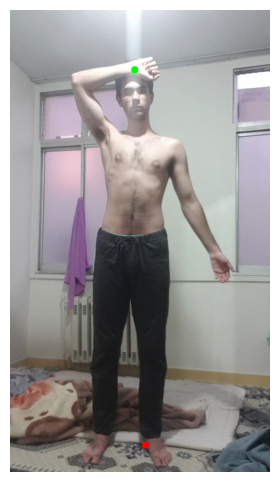

In [4]:
image = cv2.imread('input/Front.jpg')
image_height, image_width, _ = image.shape
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
landmarks = results.pose_landmarks.landmark

head_y = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y * image_height
foot_y = landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y * image_height
head_x = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x * image_width
foot_x = landmarks[mp_pose.PoseLandmark.LEFT_HEEL].x * image_width

cv2.circle(image, (int(head_x), int(head_y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(foot_x), int(foot_y)), 10, (0, 0, 255), -1)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Calculate the ratio in frontal picture

In [5]:
head_y = landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y * image_height
foot_y = landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y * image_height
frontal_image_pixel_size = HEIGHT / abs(head_y - foot_y)

### Calculate left femur length in cm in frontal picture

In [6]:
left_knee_y = landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y * image_height
left_ankle_y = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y * image_height
left_knee_x = landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x * image_width
left_ankle_x = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x * image_width
left_shank_length_in_cm = math.sqrt((left_knee_y - left_ankle_y) * (left_knee_y - left_ankle_y) + (left_knee_x - left_ankle_x) * (left_knee_x - left_ankle_x)) * frontal_image_pixel_size

### Use the calculated left femur length for the left image to calculate the ratio for the left image

In [7]:
image = cv2.imread('input/Left.jpg')
image_height, image_width, _ = image.shape
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
landmarks = results.pose_landmarks.landmark

left_knee_y = landmarks[mp_pose.PoseLandmark.LEFT_KNEE].y * image_height
left_ankle_y = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].y * image_height
left_knee_x = landmarks[mp_pose.PoseLandmark.LEFT_KNEE].x * image_width
left_ankle_x = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE].x * image_width
left_shank_length_in_pixel = math.sqrt((left_knee_y - left_ankle_y) * (left_knee_y - left_ankle_y) + (left_knee_x - left_ankle_x) * (left_knee_x - left_ankle_x))

left_image_pixel_size = left_shank_length_in_cm / left_shank_length_in_pixel

# Segment the head and torso in the frontal and left picture

In [8]:
frontal_image_segments = BodyPartSegmentation.get_segmentation_of_frontal_image()
left_image_segments = BodyPartSegmentation.get_segmentation_of_left_image()

### See how segmented pictures look like

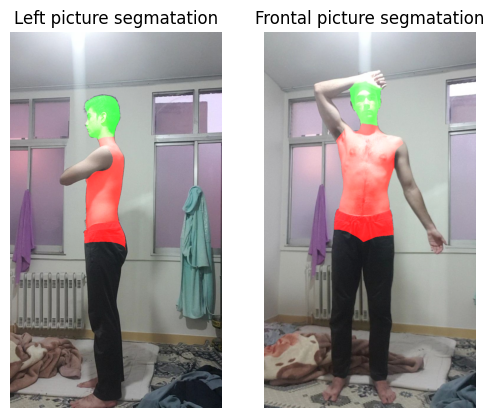

In [26]:
frontal_seg_canvas = human_seg_combine_argmax(frontal_image_segments)
frontal_cur_canvas = cv2.imread('input/Front.jpg')
frontal_canvas = cv2.addWeighted(frontal_seg_canvas, 1, frontal_cur_canvas, 1, 0.5)

frontal_seg_image_rgb = cv2.cvtColor(frontal_canvas, cv2.COLOR_BGR2RGB)

left_seg_canvas = human_seg_combine_argmax(left_image_segments)
left_cur_canvas = cv2.imread('input/Left.jpg')
left_canvas = cv2.addWeighted(left_seg_canvas, 1, left_cur_canvas, 1, 0.5)

left_seg_image_rgb = cv2.cvtColor(left_canvas, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(6, 5))
axes[0].set_title('Left picture segmatation')
axes[1].set_title('Frontal picture segmatation')

axes[0].imshow(left_seg_image_rgb)
axes[0].axis('off')
axes[1].imshow(frontal_seg_image_rgb)
axes[1].axis('off')

plt.show()

# Calculate neck circumference

### Calculate neck front radius

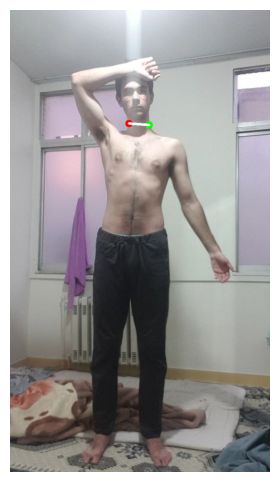

In [10]:
neck_bottom_left_x = 0
neck_bottom_left_y = 0
neck_bottom_right_x = 0
neck_bottom_right_y = 0

max_y_left = 0
max_y_right = 0

for y in range(frontal_image_segments.shape[0]):
    for x in range(frontal_image_segments.shape[1]):
        if frontal_image_segments[y][x] == 2:
            break

        if frontal_image_segments[y][x] == 1 and y > max_y_left:
            neck_bottom_left_x = x
            neck_bottom_left_y = y
            break

    for x in range(frontal_image_segments.shape[1] - 1, -1, -1):
        if frontal_image_segments[y][x] == 2:
            break

        if frontal_image_segments[y][x] == 1 and y > max_y_right:
            neck_bottom_right_x = x
            neck_bottom_right_y = y
            break

neck_frontal_radius_in_pixel = math.sqrt((neck_bottom_left_x - neck_bottom_right_x) * (neck_bottom_left_x - neck_bottom_right_x) + (neck_bottom_left_y - neck_bottom_right_y) * (neck_bottom_left_y - neck_bottom_right_y)) / 2
neck_frontal_radius_in_cm = neck_frontal_radius_in_pixel * frontal_image_pixel_size

image = cv2.imread('input/Front.jpg')

cv2.circle(image, (int(neck_bottom_right_x), int(neck_bottom_right_y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(neck_bottom_left_x), int(neck_bottom_left_y)), 10, (0, 0, 255), -1)
cv2.line(image, (int(neck_bottom_right_x), int(neck_bottom_right_y)), (int(neck_bottom_left_x), int(neck_bottom_left_y)), (255, 255, 255), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Calculate neck left radius

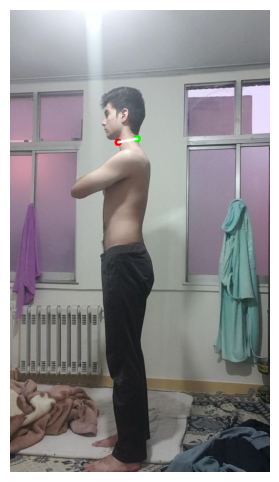

In [11]:
neck_bottom_left_x = 0
neck_bottom_left_y = 0
neck_bottom_right_x = 0
neck_bottom_right_y = 0

max_y_left = 0
max_y_right = 0

for y in range(left_image_segments.shape[0]):
    for x in range(left_image_segments.shape[1]):
        if left_image_segments[y][x] == 2:
            break

        if left_image_segments[y][x] == 1 and y > max_y_left:
            neck_bottom_left_x = x
            neck_bottom_left_y = y
            break

    for x in range(left_image_segments.shape[1] - 1, -1, -1):
        if left_image_segments[y][x] == 2:
            break

        if left_image_segments[y][x] == 1 and y > max_y_right:
            neck_bottom_right_x = x
            neck_bottom_right_y = y
            break

neck_side_radius_in_pixel = math.sqrt((neck_bottom_left_x - neck_bottom_right_x) * (neck_bottom_left_x - neck_bottom_right_x) + (neck_bottom_left_y - neck_bottom_right_y) * (neck_bottom_left_y - neck_bottom_right_y)) / 2
neck_side_radius_in_cm = neck_side_radius_in_pixel * left_image_pixel_size

image = cv2.imread('input/Left.jpg')

cv2.circle(image, (int(neck_bottom_right_x), int(neck_bottom_right_y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(neck_bottom_left_x), int(neck_bottom_left_y)), 10, (0, 0, 255), -1)
cv2.line(image, (int(neck_bottom_right_x), int(neck_bottom_right_y)), (int(neck_bottom_left_x), int(neck_bottom_left_y)), (255, 255, 255), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [12]:
neck_circumference = math.pi * (3.33 * (neck_side_radius_in_cm + neck_frontal_radius_in_cm) - math.sqrt((3.33 * neck_side_radius_in_cm + neck_frontal_radius_in_cm) * (neck_side_radius_in_cm + 3.33 * neck_frontal_radius_in_cm)))

# Calculate abdomen circumference

### Calculate abdomen front radius

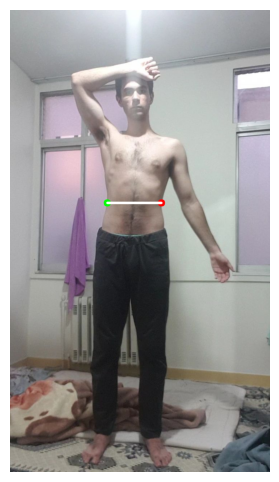

In [15]:
image = cv2.imread('input/Front.jpg')
image_height, image_width, _ = image.shape
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
landmarks = results.pose_landmarks.landmark

left_shoulder_y = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
left_shoulder_x = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width

left_hip_y = landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * image_height
left_hip_x = landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * image_width

abdomen_point_y = int((left_shoulder_y + left_hip_y) / 2)

start_point_x = 0
end_point_x = 0

for x in range(image.shape[1]):
    if frontal_image_segments[abdomen_point_y][x] == 2:
        start_point_x = x
        break

for x in range(image.shape[1] - 1, -1, -1):
    if frontal_image_segments[abdomen_point_y][x] == 2:
        end_point_x = x
        break

abdomen_front_radius_in_pixel = (end_point_x - start_point_x) / 2
abdomen_front_radius_in_cm = abdomen_front_radius_in_pixel * frontal_image_pixel_size

cv2.circle(image, (int(start_point_x), int(abdomen_point_y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(end_point_x), int(abdomen_point_y)), 10, (0, 0, 255), -1)
cv2.line(image, (int(start_point_x), int(abdomen_point_y)), (int(end_point_x), int(abdomen_point_y)), (255, 255, 255), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

### Calculate abdomen left radius

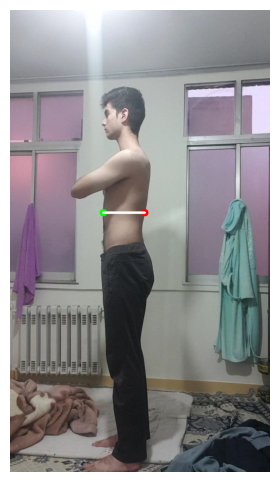

In [16]:
image = cv2.imread('input/Left.jpg')
image_height, image_width, _ = image.shape
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True)
results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
landmarks = results.pose_landmarks.landmark

left_shoulder_y = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height
left_shoulder_x = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width

left_hip_y = landmarks[mp_pose.PoseLandmark.LEFT_HIP].y * image_height
left_hip_x = landmarks[mp_pose.PoseLandmark.LEFT_HIP].x * image_width

abdomen_point_y = int((left_shoulder_y + left_hip_y) / 2)

start_point_x = 0
end_point_x = 0

for x in range(image.shape[1]):
    if left_image_segments[abdomen_point_y][x] == 2:
        start_point_x = x
        break

for x in range(image.shape[1] - 1, -1, -1):
    if left_image_segments[abdomen_point_y][x] == 2:
        end_point_x = x
        break

abdomen_side_radius_in_pixel = (end_point_x - start_point_x) / 2
abdomen_side_radius_in_cm = abdomen_side_radius_in_pixel * left_image_pixel_size

cv2.circle(image, (int(start_point_x), int(abdomen_point_y)), 10, (0, 255, 0), -1)
cv2.circle(image, (int(end_point_x), int(abdomen_point_y)), 10, (0, 0, 255), -1)
cv2.line(image, (int(start_point_x), int(abdomen_point_y)), (int(end_point_x), int(abdomen_point_y)), (255, 255, 255), 5)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

In [17]:
abdomen_circumference = math.pi * (3.33 * (abdomen_front_radius_in_cm + abdomen_side_radius_in_cm) - math.sqrt((3.33 * abdomen_front_radius_in_cm + abdomen_side_radius_in_cm) * (abdomen_front_radius_in_cm + 3.33 * abdomen_side_radius_in_cm)))

# Predict body fat with a parametric fat estimation model

In [21]:
bodyFatPercentage = ParametricBodyFatEstimation.parametricBodyFatEstimation(SEX, HEIGHT / 100, neck_circumference, abdomen_circumference)
print(f'Body fat percentage of this person is {int(bodyFatPercentage)}%')

Body fat percentage of this person is 15%
